# Google Merchandise Store Data

Imports

In [159]:
import json
import pyspark as ps
import pandas as pd
import numpy as np
import datetime
from dateutil import relativedelta
from tqdm.notebook import trange, tqdm
from datetime import datetime
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm


import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu 

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff



Data Cleaning

In [224]:
from google.cloud import bigquery
from google.oauth2 import service_account
#I set my global variable to my google credentials.


project_id = 'spheric-method-283202'

# TODO(developer): Set key_path to the path to the service account key
#                  file.
# key_path = "path/to/service_account.json"

credentials = service_account.Credentials.from_service_account_file(
    "/Users/Cliff/dev/google_key.json",
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

# Construct a reference to the "google_analytics_sample" dataset
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")



In [10]:
#Dates

sdate = datetime.date(2016,8,1)
edate = datetime.date(2017,8,1)

In [4]:
def clean_dates(sdate, edate):
    date_lst = []
    cleaned = []
    x = pd.date_range(sdate,edate,freq='d')
    for i in x:
        date_lst.append(pd.to_datetime(str(i)).strftime('%Y.%m.%d'))
    
    for date in date_lst:
        cleaned.append(date.replace('.',''))
    return cleaned
clean_dates = clean_dates(sdate,edate)


In [2]:
def filter_dict(dictionary, keys):
    #Takes dictionary and created new on based on keys wanted. 
    
    return {k: dictionary[k] for k in keys if k in dictionary}


def filter_dict_dict(embeded_dictionary):
    #Goes into filter_dict. Attempt to clean dictionary within dictionary.
    ecommerceaction = ['action_type']
    page = ['pagePath', 'pageTitle']
    product = ['productSKU', 'v2ProductName', 'v2ProductCategory', 'productVariant', 
           'productRevenue', 'productPrice', 'productQuantity']
    transactions = ['transactionId', 'transactionRevenue', 'transactionTax', 'transactionShipping']
    if embeded_dictionary == 'eCommerceAction':
        return {k: embeded_dictioanry[k] for k in emcommerceaction if k in embeded_dictionary}
    elif embeded_dictionary == 'page':
        return {k: embeded_dictioanry[k] for k in page if k in embeded_dictionary}
    elif embeded_dictionary == 'product':
        return {k: embeded_dictioanry[k] for k in product if k in embeded_dictionary}
    elif embeded_dictionary == 'transactions':
        return {k: embeded_dictioanry[k] for k in transactions if k in embeded_dictionary}
    else:
        pass

def literal_return(value):
    #Attempts to read each column string and convert to appropriate data type.
    try:
        return ast.literal_eval(value)
    except:
        return value
    
def filter_dict(dictionary, keys):
    #Takes dictionary and created new on based on keys wanted. 
    return {k: dictionary[k] for k in keys if k in dictionary}

def get_all_dataframes(date_list):
    df = pd.DataFrame()
    for i in tqdm(range(len(date_list))):
        # Construct a reference to the "ga_sessions_20170801" table
        table_ref = dataset_ref.table("ga_sessions_"+str(date_list[i]))

        # API request - fetch the table
        table = client.get_table(table_ref)
        
        #Columns Want
        columns = ['visitId', 'visitStartTime',
                  'date', 'totals', 'trafficSource', 'device',
                   'geoNetwork', 'channelGrouping'] #'hits'
        
        #First dataframe
        month_df = client.list_rows(table).to_dataframe()
        month_df = month_df[columns]
        
        #Turn columns into appropriate datatypes. 
        for column in columns:
            try:
                month_df[column] = month_df[column].apply(lambda x: literal_return(x))
            except:
                pass
        
        #Go into columns and remove useless data
        for column in columns:
            try:
                month_df[column] = month_df[column].apply(lambda x: {k:v for k,v in x.items() if v != 'not available in demo dataset'})
            except:
                pass
            
        #Keys I want to keep in each column dict.
        totals = ['hits', 'pageviews','timeOnSite','totalTransactionRevenue']
        trafficsource = ['referralPath', 'source','medium','adContent']
        hits = ['hitNumber', 'time','hour','minute','eCommerceAction', 
        'product', 'transactions']
        
        month_df['totals'] = month_df['totals'].apply(lambda x: filter_dict(x,totals))
        month_df['trafficSource'] = month_df['trafficSource'].apply(lambda x: filter_dict(x,trafficsource))
        #month_df['hits'] = month_df['hits'].apply(lambda y: list(map(lambda x: filter_dict(x,hits), y)))
        
        #Combine df
        df = pd.concat([df, month_df], axis = 0)
        df.reset_index(drop=True, inplace=True)
    
    df.to_json("test")
    
#get_all_dataframes(clean_dates)

In [3]:
def parse_dataframe(df):
    final_df = pd.DataFrame()
    for i in tqdm(range(0,len(df))):
        temp_row = df[i:i+1]
        final_df = final_df.append(parse_col(temp_row))
        final_df.reset_index(drop=True, inplace=True)
    return final_df
        
def parse_col(df):
    #Take downloaded data and parse out dictionaries into expanded dataframe.
    new_df = pd.DataFrame()  
    for col in df:
        if df[col].dtypes == 'O':
            temp = df[col].apply(pd.Series)
            new_df = pd.concat([new_df, temp], axis = 1)
        else:
            new_df = pd.concat([new_df, df[col]], axis = 1)

    return new_df
#df_clean = parse_dataframe(df)

Data Schema Mapping

Columns needed:
-visitId
-visitStartTime
-date

totals
    -hits
    -pageviews
    -timeOnSite
    -totaltransactionRevenue
   
trafficSource
    -referralPath
    -source
    -medium
    -keyword [I dont understand - remove]
    -adContent
device
    - [Get all]
geoNetwork
    - [Get all]
hits [Each is a list of dictionaries representing a page view]
    -hitNumber
    -time
    -hour
    -minute
    -eCommerceAction [Get only action_type]
    -page ['pagePath', 'pageTitle'] [Remove]
    -product [Get all remove later]
        -productSKU
        -v2ProductName
        -v2ProductCategory
        -productVariant
        -productRevenue
        -productPrice
        -productQuantity
    -transactions [Get all remove later]
        -transactionId
        -transactionRevenue
        -transactionTax
        -transactionShipping

channelGrouping
    

# Data Plotting

In [207]:
df = pd.read_csv('../ga_data.csv')

In [486]:
df = pd.read_csv('../ga_data_no_outliers.csv')

In [ ]:
#df_parse = split_dates(df)

In [324]:
def bar_chart(df, columngroup, column, other, title=None):
    df = create_other(df, columngroup, column, other)
    plt.style.use('ggplot')

    x = df.index
    data = df[column]
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, data, color='green')
    plt.xlabel('Country')
    plt.ylabel('Total Revenue')
    plt.title(title)

    
    plt.xticks(x_pos, x)

    plt.show()

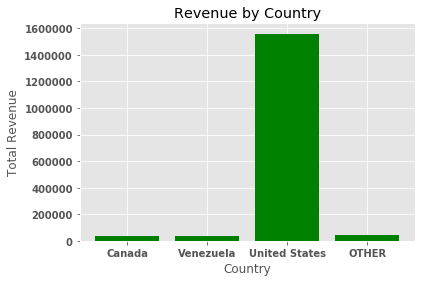

In [487]:
bar_chart(df, 'country', 'totalrevenue', 0.01, 'Revenue by Country')

In [276]:
#Parse out dates in csv for easily plotting.
def split_dates(df):
    temp = df.copy()
    for i in tqdm(range(len(df))):
        temp_list = temp['Date'][i].split('-')
        temp['Month-Year'] = temp_list[1]+'-'+temp_list[0]
        temp['Day'] = temp_list[2]
    return df

#Takes dataframe, groups, finds groups below "other" threshold and combines them.
def create_other(df, columngroup, column, other):
    """
    INPUT:
    df = Dataframe
    columngroup = Column to groupby
    column = Column to sum
    other = threshold
    
    OUTPUT:
    Dataframe
    """
    #Group dataframe by columngroup and sum column.
    group = df.groupby([columngroup]).sum().sort_values(column)
    #Two dataframes one to stores values above and below "other" threshold.
    groups = pd.DataFrame()
    other_df = pd.DataFrame()
    for i in range(0,len(group)):
        if group.iloc[i:i+1][column][0]/sum(group[column]) < other:
            other_df = other_df.append(group.iloc[i:i+1])
        else:
            groups = groups.append(group.iloc[i:i+1])
    #Group groups into one row called other. 
    other_df['OTHER'] = 'OTHER'
    other_df = other_df.groupby('OTHER').sum()
    if other_df.empty:
        return groups
    else:
        if ((other_df[column]/sum(group[column])) < other)[0] ==True:
            return groups
        else:
            groups = groups.append(other_df)
            return groups
   
def pie_chart(df, columngroup, column, other, explode=None, title=None):
    #Groups dataframe, see create_other function
    group = create_other(df, columngroup, column, other)
    
    labels = group.index
    sizes = (group[column]/sum(group[column]))
    colors = plt.cm.tab20(range(20))
    
    explodes = None
    if explode !=None:
        explode_list = [0]*len(labels)
        explode_list[explode] = .09
        explodes = explode_list

    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.pie(sizes, explode=explodes, labels=labels, autopct='%1.1f%%', 
         pctdistance=.6, labeldistance=1.04, shadow=True, startangle=20
           ,colors = colors)
    ax.axis('equal')  
    
    mpl.rcParams['font.size'] = 14.0
    plt.title(f'{title}', color='w', bbox={'facecolor':'black', 'pad':7})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rc('font', weight='bold')
    plt.tight_layout()
    plt.show()

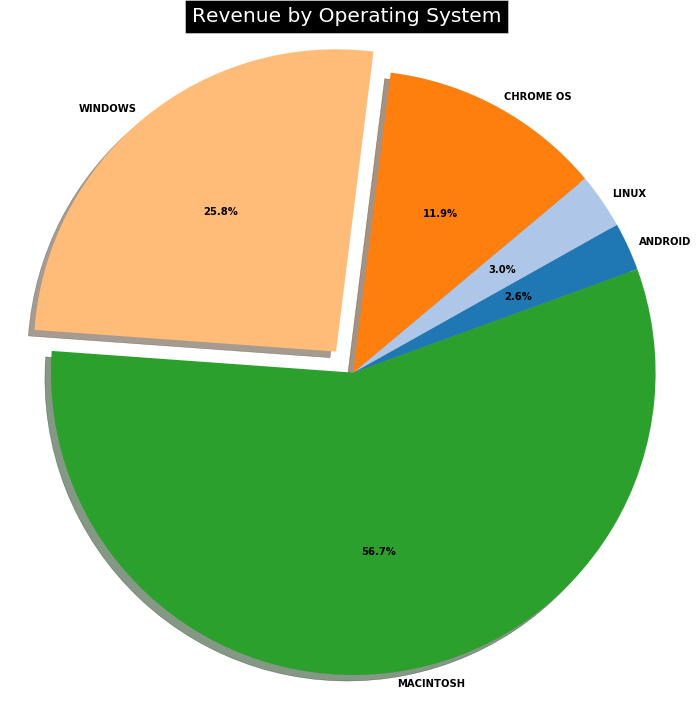

In [488]:
pie_chart(df, 'operatingsystem', 'totalrevenue', .02, 3, 'Revenue by Operating System')

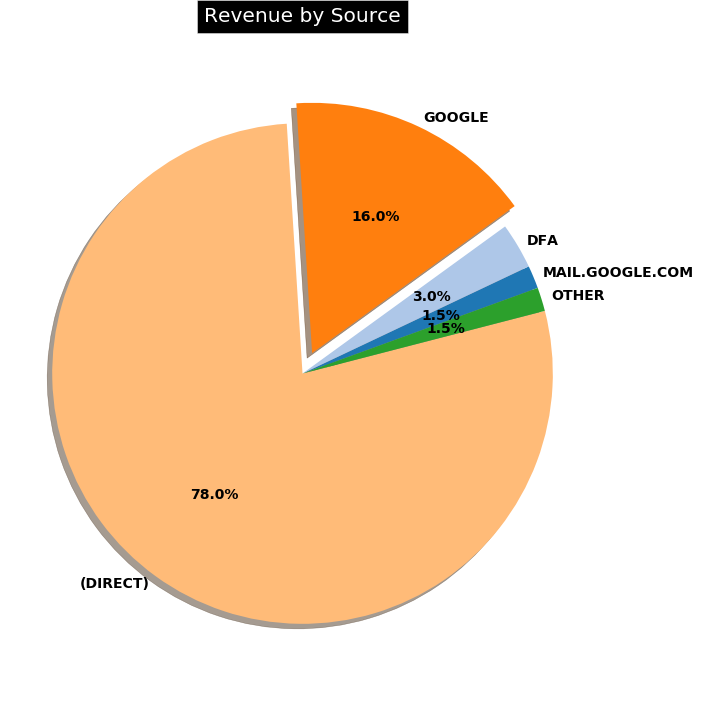

In [480]:
pie_chart(df, 'source', 'totalrevenue', .01, 2, 'Revenue by Source')

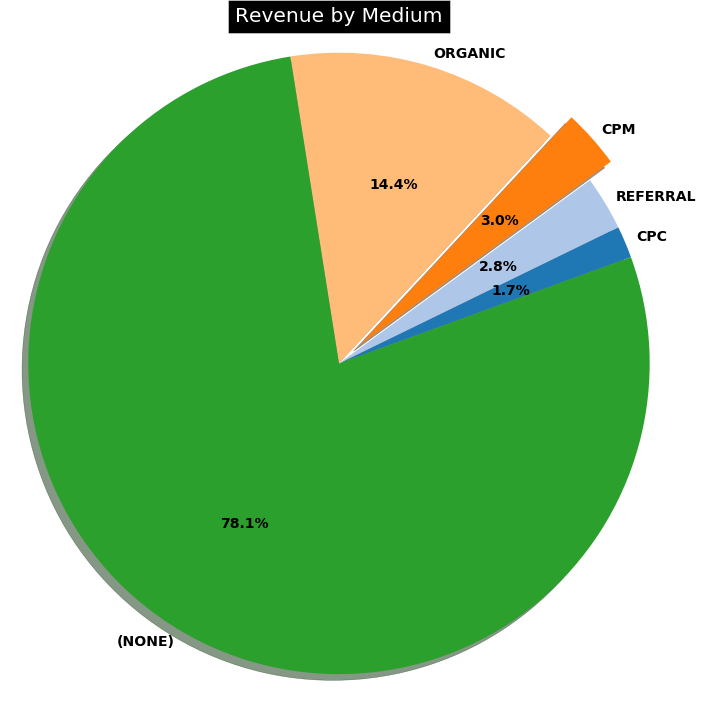

In [529]:
pie_chart(df, 'medium', 'totalrevenue', 0.015, 2, 'Revenue by Medium')

In [389]:
def plot_full_scatter(df, column, title=None):
    group = df.groupby('date').sum()

    x = group.index
    y = group[column]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, name='High 2014',
                         line=dict(color='firebrick', width=4)))
    
    figsize = (15,20)
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    y_axis = column.title()
    fig.update_layout(title=title,
                   xaxis_title= 'Month-Year',
                   yaxis_title= y_axis)
    fig.show()


In [482]:
plot_full_scatter(df,'totalrevenue', 'Time Series - Total Revenue')


In [179]:
def format_(x):
    return "${:.1f}K".format(x/1000)

def ratios_table(df, column, threshold=.02):
    group = create_other(df, column, 'totalrevenue', threshold)
    #group = group.drop(['yearmonth','day'], axis = 1)
    x = group[['pageviews', 'timeonsite', 'totalrevenue']].div(group.visit, axis=0)
    total_rev = group['totalrevenue']
    percent = group['totalrevenue']/sum(group['totalrevenue'])
    
    x['Total_Revenue'] = total_rev
    x['Percent'] = percent
    
    x = round(x,2)
    x.Percent = x.Percent.mul(100).round(2).astype(str).add('%')
    x.Total_Revenue = x.Total_Revenue.apply(format_)

    headerColor = 'grey'
    rowEvenColor = 'lightgrey'
    rowOddColor = 'white'

    fig = go.Figure(data=[go.Table(
      header=dict(
        values=['<b>INDEX</b>','<b>Pages</b>',
                '<b>Time</b>','<b>Revenue</b>',
                '<b>Total Revenue</b>', '<b>Revenue (%)</b>'],
        line_color='darkslategray',
        fill_color=headerColor,
        align=['left','center'],
        font=dict(color='white', size=12)
      ),
      cells=dict(
        values=[x.index,
          x['pageviews'],
          x['timeonsite'],
          x['totalrevenue'],
          x['Total_Revenue'],
          x['Percent']],
        line_color='darkslategray',
        # 2-D list of colors for alternating rows
        fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*(len(x))],
        align = ['left', 'center'],
        font = dict(color = 'darkslategray', size = 12)
        ))
    ])
    
    
    fig.show()



In [490]:
ratios_table(df, 'medium')

In [285]:

def ratios_barchart(df, column, threshold=.02, title=None):
    group = create_other(df, column, 'totalrevenue', threshold)
    #group = group.drop(['yearmonth','day'], axis = 1)
    x = group[['pageviews', 'timeonsite', 'totalrevenue']].div(group.visit, axis=0)
    total_rev = group['totalrevenue']
    
    x['Total_Revenue'] = total_rev
    
    x.Total_Revenue = x.Total_Revenue.apply(format_)
    x.timeonsite = x.timeonsite/60
    x = x.round(2)
    x.reset_index(level=0, inplace=True)
    
    column_title = column.title()
    x.columns = [column_title, 'Page Views/Visit','Time/Visit (min)','Revenue/Visit','Total Revenue']

    fig = ff.create_table(x, height_constant=60)
    fig.add_trace(go.Bar(x=x[column_title], y=x['Page Views/Visit'], xaxis='x2', yaxis='y2',
                marker=dict(color='#0099ff'),
                name='Page Views<br>Per Visit'))

    fig.add_trace(go.Bar(x=x[column_title], y=x['Time/Visit (min)'], xaxis='x2', yaxis='y2',
                marker=dict(color='#404040'),
                name='Time<br>Per Visit'))
    
    fig.add_trace(go.Bar(x=x[column_title], y=x['Revenue/Visit'], xaxis='x2', yaxis='y2',
                marker=dict(color='#FF3030'),
                name='Revenue<br>Per Visit'))
                                        
    fig.update_layout(
    title_text = f'{title}',
    height = 800,
    width = 900,
    margin = {'t':75, 'l':50},
    yaxis = {'domain': [0, .45]},
    xaxis2 = {'anchor': 'y2'},
    yaxis2 = {'domain': [.6, 1], 'anchor': 'x2'})
    fig.show()
    

In [491]:
ratios_barchart(df, 'operatingsystem', .02, 'Operating System Ratios')

In [492]:
ratios_barchart(df, 'source', .015, 'Operating System Ratios')

In [493]:
ratios_barchart(df, 'medium', .015, 'Medium Ratios')

# Hypothesis Testing

Import Data

In [407]:
df_cpc = pd.read_csv('../cpc_data.csv')
df_cpm = pd.read_csv('../cpm_data.csv')

In [494]:
df_cpc = pd.read_csv('../cpc_data.csv')
df_cpm = pd.read_csv('../cpm_data_no_outliers.csv')

In [523]:
def purchase01_clean(df, column):
    df['purchase'] = np.where(df[column]>0, 1, 0)
    df['totalrevenue'] = df['totalrevenue'].apply(lambda x: x if x>0 else 0)
    return df

def buy_hit_rate(df):
    x = df[df['totalrevenue']>0]
    return round(len(x)/len(df),3)

def buy_graph(df1, df2):
    df1_hit = len(df1[df1['totalrevenue']>0])
    df1_total = len(df1)
    
    df2_hit = len(df2[df2['totalrevenue']>0])
    df2_total = len(df2)
    

    shared_sample_freq = (df1_hit + df2_hit) / (df1_total + df2_total)
    shared_sample_variance = (df1_total + df2_total) * (shared_sample_freq * (1 - shared_sample_freq)) / (df1_total*df2_total)
    difference_in_proportions = stats.norm(0, np.sqrt(shared_sample_variance))

    cpc_sample_freq = df1_hit / df1_total
    cpm_sample_freq = df2_hit / df2_total
    difference_in_sample_proportions = cpc_sample_freq - cpm_sample_freq
    print("Difference in sample proportions: {:2.2f}".format(difference_in_sample_proportions))
    
    p_value = 1 - difference_in_proportions.cdf(difference_in_sample_proportions)

    fig, ax = plt.subplots(1, figsize=(16, 3))

    x = np.linspace(-1, 1, num=5)
    ax.plot(x, difference_in_proportions.pdf(x), linewidth=3)
    ax.fill_between(x, difference_in_proportions.pdf(x), where=(x >= difference_in_sample_proportions),
                    color="red", alpha=0.5)
    ax.set_xlim(-1, 1)
    ax.set_title("p-value Reigon")
    
def p_value(cpm, cpc, column):
    res = stats.mannwhitneyu(cpm[column], cpc[column], alternative="greater")
    print(f"p-value for CPM > CPC ({column}): {res.pvalue.round(3)}")
    if column == 'purchase':
        print(f"Purchase Rate Per Visit (CPM): {str(round(buy_hit_rate(df_cpm)*100,2))+'%'}")
        print(f"Purchase Rate Per Visit (CPC): {str(round(buy_hit_rate(df_cpc)*100,2))+'%'}")

Clean Data

In [495]:
cpc = purchase01_clean(df_cpc, 'totalrevenue')

In [496]:
cpm = purchase01_clean(df_cpm, 'totalrevenue')

In [497]:
cpc['purchase'].sum()

242

In [498]:
cpm['purchase'].sum()

138

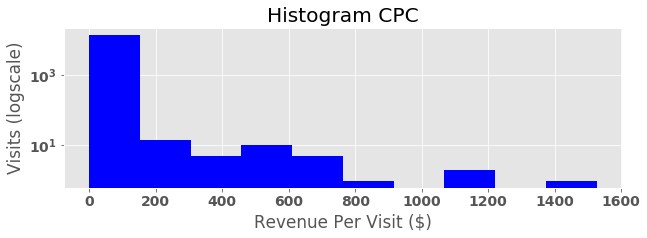

In [499]:
a = cpc.totalrevenue
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(3, 1, 1)

line = ax.hist(a, color='blue', lw=2)
ax.set_title('Histogram CPC')
ax.set_xlabel('Revenue Per Visit ($)')
ax.set_ylabel('Visits (logscale)')
ax.set_yscale('log')


plt.show()

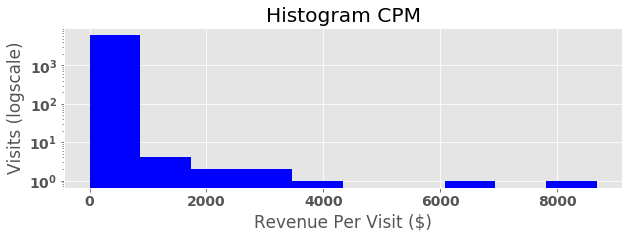

In [500]:
a = cpm.totalrevenue
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(3, 1, 1)

line = ax.hist(a, color='blue', lw=2)

ax.set_title('Histogram CPM')
ax.set_xlabel('Revenue Per Visit ($)')
ax.set_ylabel('Visits (logscale)')

ax.set_yscale('log')


plt.show()

Difference in sample proportions: -0.00


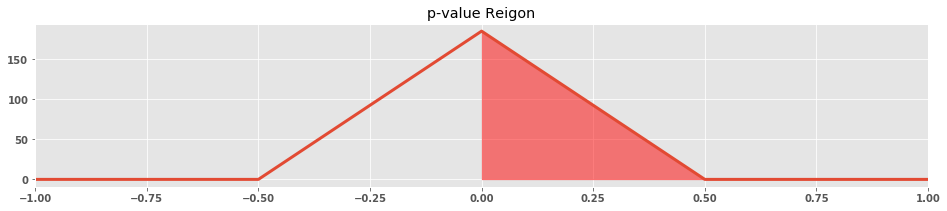

In [399]:
buy_graph(df_cpc, df_cpm)

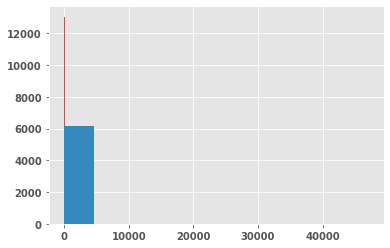

In [415]:
plt.hist(cpc.totalrevenue)
plt.hist(cpm.totalrevenue)
plt.show()

In [524]:
p_value(cpm, cpc, 'purchase')

p-value for CPM > CPC (purchase): 0.038
Purchase Rate Per Visit (CPM): 2.2%
Purchase Rate Per Visit (CPC): 1.9%


In [525]:
p_value(cpm, cpc, 'totalrevenue')

p-value for CPM > CPC (totalrevenue): 0.033


In [526]:
p_value(cpm, cpc, 'pageviews')

p-value for CPM > CPC (pageviews): 0.618


In [527]:
p_value(cpm, cpc, 'timeonsite')

p-value for CPM > CPC (timeonsite): 1.0
